In [43]:
using Revise
using RxInfer, Random, LinearAlgebra, Distributions, Plots, StatsPlots, Flux, DelimitedFiles, StableRNGs
using CCMP

In [44]:
# # define CVMP forward rule
# @rule DeltaFn(:out, Marginalisation) (q_ins::ReactiveMP.FactorizedJoint{P}, meta::ReactiveMP.DeltaMeta{M}) where {P <: NTuple{1}, M <: CVI} = begin
#     @info "Excuted"
#     method = ReactiveMP.getmethod(meta)
#     node = getnode()
#     m_out = Rocket.getrecent(ReactiveMP.messagein(node.out))
#     m_ins = Rocket.getrecent.(ReactiveMP.messagein.(node.ins))
#     # Debug:
#     @info "marginal" q_ins
#     @info "input messages" m_ins
#     @info "output messages" m_out
  
#     q_y_params = naturalparams(prod(method, getdata(m_ins[1]), getdata(m_out), q_ins[1], getnodefn(Val(:out))))
#     # @info "Output:"
#     # @info convert(Distribution, q_y_params - naturalparams(getdata(m_out)))
#     @info "finished"
#     return convert(Distribution, q_y_params - naturalparams(getdata(m_out)))
# end

<!-- ┌ Info: HERE!
└ @ Main /Users/sabinamakhmudova/repos/CVMP/demos/sunspot_gamma.ipynb:7
┌ Info: ReactiveMP.FactorizedJoint{Tuple{GammaShapeRate{Float64}}}((GammaShapeRate{Float64}(a=13605.986147431206, b=13.435354995502149),))
└ @ Main /Users/sabinamakhmudova/repos/CVMP/demos/sunspot_gamma.ipynb:8
┌ Info: (Message(Gamma{Float64}(α=1000.0, θ=1.0)),)
└ @ Main /Users/sabinamakhmudova/repos/CVMP/demos/sunspot_gamma.ipynb:9
┌ Info: Message(GammaShapeRate{Float64}(a=1.0, b=1.0))
└ @ Main /Users/sabinamakhmudova/repos/CVMP/demos/sunspot_gamma.ipynb:10
Output exceeds the size limit. Open the full output data in a text editorMethodError: no method matching prod(::ProdCVI{StableRNGs.LehmerRNG, Descent, ForwardDiffGrad, false}, ::Gamma{Float64}, ::GammaShapeRate{Float64}, ::GammaShapeRate{Float64}, ::typeof(identity))
Closest candidates are:
  prod(!Matched::ProdGeneric, ::Any, ::Any, ::Any, ::Any, !Matched::DistProduct, !Matched::DistProduct) at ~/.julia/packages/ReactiveMP/Dm45i/src/constraints/prod/prod_generic.jl:123
  prod(::ProdCVI, ::Any, ::Any) at ~/.julia/packages/ReactiveMP/Dm45i/src/approximations/cvi.jl:93
  prod(!Matched::ReactiveMP.EqualityChain, ::Any, ::Any) at ~/.julia/packages/ReactiveMP/Dm45i/src/nodes/equality.jl:78
  ... -->


In [45]:
# to check that matched with Semih
sunspot_semih = readdlm("data/SN_Akbayrak.csv")
semih_observations = map(Int, sunspot_semih[:,2]);

5 colums dataset
https://www.sidc.be/silso/infosnytot
Contents:

Column 1: Gregorian calendar year (mid-year date)

Column 2: Yearly mean total sunspot number.

Column 3: Yearly mean standard deviation of the input sunspot numbers from individual stations.

Column 4: Number of observations used to compute the yearly mean total sunspot number.

Column 5: Definitive/provisional marker. A blank indicates that the value is definitive. A '*' symbol indicates that the

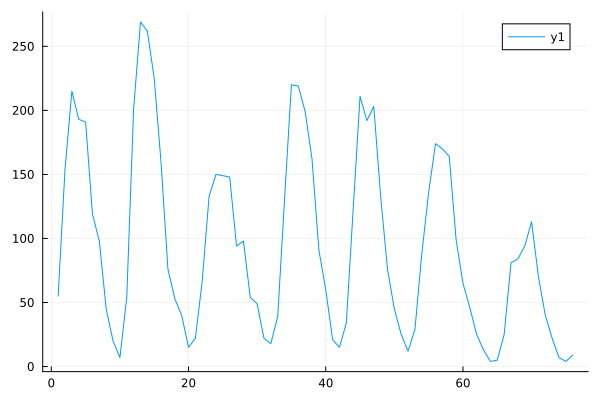

In [46]:
sunspot = readdlm("data/SN_y_tot_V2.0.csv", ';')
select_1945_2020 = filter((s) -> s[1] > 1945 && s[1] < 2021, collect(eachrow(sunspot)))
observations = map((s) -> round(s[2]), select_1945_2020)
@assert semih_observations == observations
plot(observations)


In [47]:
@model function sunspot_model(nr_observations)

    γ ~ GammaShapeRate(1000.0, 1)
    z = randomvar(nr_observations)
    y = datavar(Float64, nr_observations)
    
    # specify estimate of initial location
    z[1] ~ GammaShapeRate(1, identity(γ))
    y[1] ~ Poisson(z[1])
    for t in 2:nr_observations
        # specify state transition model
        z[t] ~ GammaShapeRate(identity(z[t-1]), identity(γ))
        y[t] ~ Poisson(z[t])
    end
end

@meta function sunspot_meta(rng, nr_samples, nr_iterations, optimizer)
    identity() -> CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), 100, Val(false), true)
end;

@constraints function sunspot_constraints()
    q(γ, z) = q(γ)q(z)
    q(z) = q(z[begin])..q(z[end])
end;

@model function sunspot_model(nr_observations)

    γ ~ GammaShapeRate(1000.0, 1)
    z = randomvar(nr_observations)
    z_dummy = randomvar(nr_observations-1)
    y = datavar(Float64, nr_observations)
    
    # specify estimate of initial location
    z[1] ~ GammaShapeRate(1, γ)
    y[1] ~ Poisson(z[1])
    for t in 2:nr_observations
        # specify state transition model
        z_dummy[t-1] ~ identity(z[t-1])
        z[t] ~ GammaShapeRate(z_dummy[t-1], γ)
        y[t] ~ Poisson(z[t])
    end
end

@meta function sunspot_meta(rng, nr_samples, nr_iterations, optimizer)
    identity() -> CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), 50, Val(true), true)
end;

@constraints function sunspot_constraints()
    q(γ, z, z_dummy) = q(γ)q(z)q(z_dummy)
    q(z) = q(z[begin])..q(z[end])
end;



In [50]:
# z_init = map(r -> NormalMeanPrecision(r, 10), 1:50)
nr_observations = length(observations)
results = inference(
    model = sunspot_model(nr_observations),
    data = (y = observations,),
    iterations = 100,
    # free_energy = true,
    constraints = sunspot_constraints(),
    meta = sunspot_meta(StableRNG(42), 2000, 20, Flux.Descent(0.001)),
    initmessages = (γ=Gamma(1000.0, 1), z=Gamma(1000.0, 1), z_dummy=Gamma(1000.0, 1)),
    initmarginals = (γ=Gamma(1000.0, 1), z=Gamma(1000.0, 1), z_dummy=Gamma(1000.0, 1))
)

Inference results:
  Posteriors       | available for (γ, z_dummy, z)


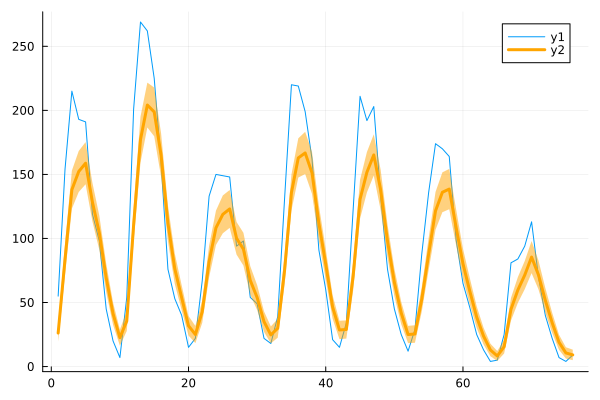

In [51]:
# plot estimates for location
posteriours = results.posteriors[:z][end]
means = map(mean, posteriours) 
ribbon = map(x -> 2*std(x), posteriours)

p1 = plot(observations)
plot!(means, ribbon=ribbon, fillalpha=0.5, linewidth=3, color = :orange)